In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

### Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


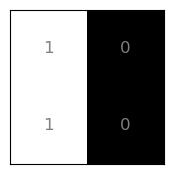

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

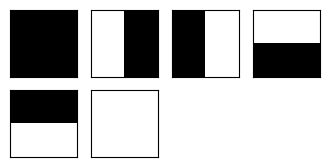

In [4]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [5]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)

[0, 10, 5, 12, 3, 15]


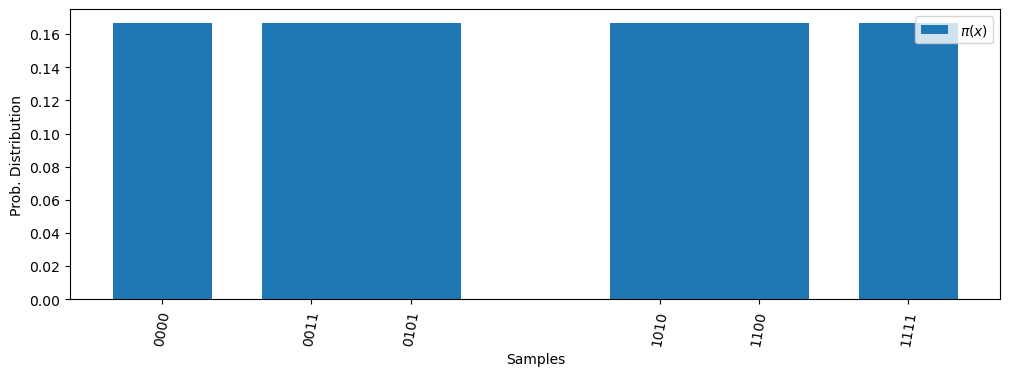

In [6]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [7]:
py_psi = np.zeros(2**size,dtype=complex)
amp = 1 / math.sqrt(len(data))
for i in nums:
    py_psi[i] = amp

target_dm = np.outer(py_psi,py_psi.conj())

### Functions

In [8]:
from pennylane.math import reduce_statevector
from pennylane import math as qmlmath

n_qubits = 4
n_ancillas = 4
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = qmlmath.conj(qmlmath.transpose(pxy)) # Compute Hermitian conjugate
        return 0.5 * qmlmath.trace(qmlmath.sqrt_matrix(dagger_pxy * pxy))
        # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        full_psi = self.circ(params)
        px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.trdistance(px,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

In [21]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        # qml.RX(ising_params1[i],wires=i)
        # qml.RY(ising_params2[i],wires=i)
        qml.RZ(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])

    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):
    
    # params = input_params.reshape((folds,3*total_qubits))
    # params = qnp.array(params,requires_grad=True)
    params = qnp.array(input_params, requires_grad=True)
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=params[i],total_qubits=total_qubits)
    
    # output1 = qml.density_matrix(wires = [i for i in range(num_qubits)])
    output1 = qml.state()
    # output2 = qml.density_matrix([(num_qubits+i) for i in range(n_ancillas)])
    return output1


### Training the Model

In [30]:
key = jax.random.PRNGKey(1)
initial_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * total_qubits), requires_grad=True)

#initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=2*math.pi)

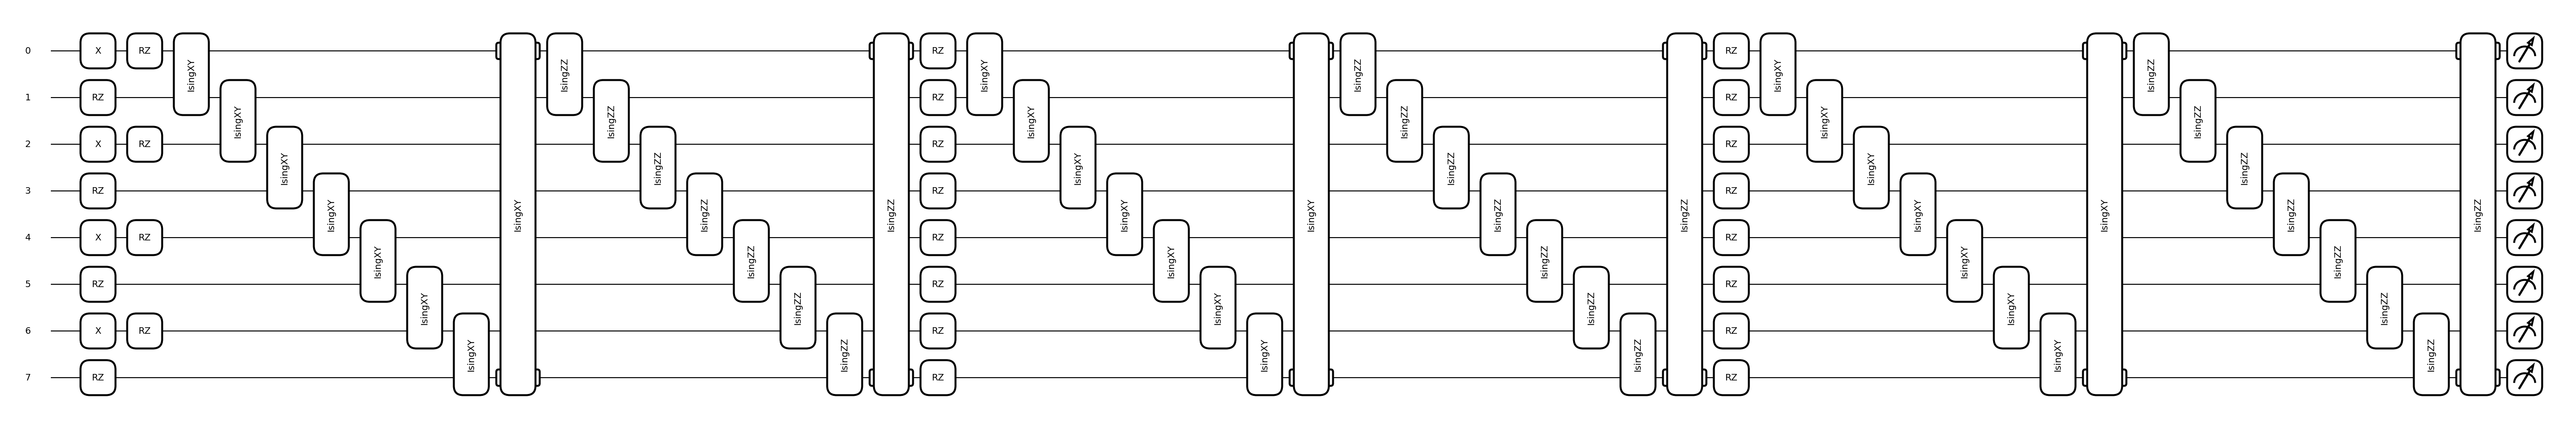

In [31]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [32]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params#.flatten()
# lr = 1
opt = AdamOptimizer(stepsize=0.01)
# opt = GradientDescentOptimizer(stepsize=0.1)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 5000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = qcbm.qcbm_loss(weights)
    weights = opt.step(qcbm.qcbm_loss,weights)
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.38219407250942405 Time taken per iter: 0.06071591377258301
Step: 20 Loss: 0.3380562522029562 Time taken per iter: 0.019482135772705078
Step: 30 Loss: 0.29936956521761343 Time taken per iter: 0.020591020584106445
Step: 40 Loss: 0.26742774474541675 Time taken per iter: 0.026710987091064453
Step: 50 Loss: 0.23850563406090555 Time taken per iter: 0.023776769638061523
Step: 60 Loss: 0.21491098883969056 Time taken per iter: 0.023590087890625
Step: 70 Loss: 0.19849077056720385 Time taken per iter: 0.02219390869140625
Step: 80 Loss: 0.1863688034061498 Time taken per iter: 0.022136211395263672
Step: 90 Loss: 0.17901959617919508 Time taken per iter: 0.019878864288330078
Step: 100 Loss: 0.17883382755011043 Time taken per iter: 0.020368099212646484
Step: 110 Loss: 0.18036910286384372 Time taken per iter: 0.020418167114257812
Step: 120 Loss: 0.17735055131322047 Time taken per iter: 0.019587993621826172
Step: 130 Loss: 0.17798590844742548 Time taken per iter: 0.01990199089050293
Ste

Text(0, 0.5, 'Trace distance Loss')

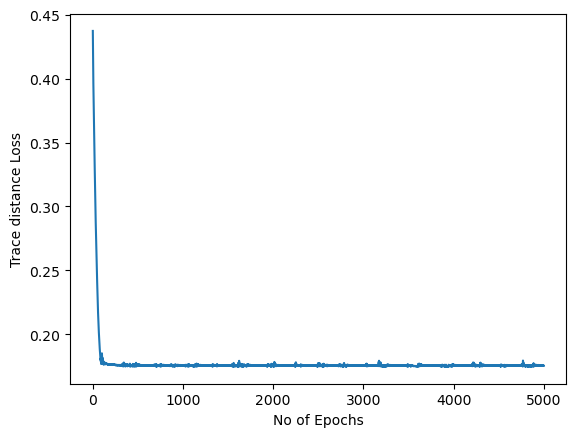

In [33]:
plt.plot(loss)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")

In [34]:
min_loss = loss[np.argmin(loss)]
# optimal_params = parameters[np.argmin(loss)]
# trained_qcbm = circuit(optimal_params)

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.17454762679419894
